In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
fake_df = pd.read_csv("Fake.csv")
real_df = pd.read_csv("True.csv")

print("Fake News Sample:")
print(fake_df.head())

print("\nReal News Sample:")
print(real_df.head())


Fake News Sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

Real News Sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip

In [5]:
fake_df['label'] = 0  # fake = 0
real_df['label'] = 1  # real = 1

df = pd.concat([fake_df, real_df], ignore_index=True)
df = df[['text', 'label']]  # only keep relevant columns
df = df.sample(frac=1).reset_index(drop=True)  # shuffle
df.head()


,text,label
0,BEIJING (Reuters) - The United States hopes th...,1
1,Trump reads his Muslim shutdown statement at a...,0
2,Isn t Alluha Akbar Islamic? I m pretty sure ...,0
3,BERLIN (Reuters) - The German government on Fr...,1
4,If you ve ever watched CSPAN you ll know how r...,0


In [6]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    return text

df['text'] = df['text'].apply(clean_text)
df.head()


,text,label
0,beijing reuters the united states hopes there...,1
1,trump reads his muslim shutdown statement at a...,0
2,isn t alluha akbar islamic i m pretty sure t...,0
3,berlin reuters the german government on frida...,1
4,if you ve ever watched cspan you ll know how r...,0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
print("Logistic Regression:", accuracy_score(y_test, lr.predict(X_test_vec)))

rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
print("Random Forest:", accuracy_score(y_test, rf.predict(X_test_vec)))

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
print("Naive Bayes:", accuracy_score(y_test, nb.predict(X_test_vec)))


Logistic Regression: 0.9866369710467706
Random Forest: 0.9874164810690423
Naive Bayes: 0.9414253897550111


In [10]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', lr),
    ('rf', rf),
    ('nb', nb)
], voting='hard')

ensemble.fit(X_train_vec, y_train)
ensemble_pred = ensemble.predict(X_test_vec)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))


Ensemble Accuracy: 0.9837416481069042


In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ensemble, vectorizer.transform(df['text']), df['label'], cv=5)
print("Cross-Validation Accuracy:", scores.mean())


Cross-Validation Accuracy: 0.9814691518517223


In [12]:
import joblib

joblib.dump(ensemble, "fake_news_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [13]:
def predict_news(text):
    cleaned = clean_text(text)
    vector = vectorizer.transform([cleaned])
    prediction = ensemble.predict(vector)
    return "Real News" if prediction[0] == 1 else "Fake News"

# Try it!
predict_news("Breaking: Government confirms new policy on AI regulations.")


'Fake News'

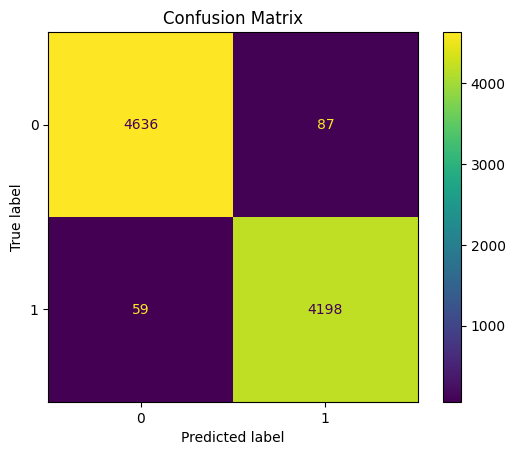

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4723
           1       0.98      0.99      0.98      4257

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, ensemble_pred)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, ensemble_pred))
